## Mass Action Model
Mass action models are the most commonly used models to describe the dynamics of many biological systems. They provide a higher-dimensional (more variables) but simple framework. They involve low-order interactions (typically linear or quadratic since they rely on the law of mass action ). The model used here is developed by Hopkins et al. , which explains the oscillatory behavior of the early embryonic cell cycle of *Xenopus laevis* based on mass action type interactions. The equations governing this model are: 

$$
\begin{align}
    \frac{du}{dt} &= k_{p,a}(A_T - u)v - k_{d,a}u(P_T - y), \\
    \frac{dv}{dt} &= k_s - b_\text{deg}uv, \\
    \frac{dw}{dt} &= k_{p,g}(G_T - w)v - k_{d,g}(P_T - y)w, \\
    \frac{dx}{dt} &= -k_{p,e}xw + k_\text{cat}y, \\
    \frac{dy}{dt} &= k_\text{ass}(E_T - x - y)(P_T - y) - k_\text{diss}y - k_\text{cat}y.
\end{align}
$$

This model consists of six interacting molecules, namely $u$, $v$, $w$, $x$, and $y$.  

### Parameters

- $ k_{p,a} = 0.4 $
- $ k_{d,a} = 100 $
- $ k_{p,g} = 0.05 $
- $ k_{diss} = 1 $
- $ k_{d,g} = 20 $
- $ k_{p,e} = 6 $
- $ k_{cat} = 4.5 $
- $ k_{ass} = 100 $
- $ k_s = 1.5 $
- $ b_{deg} = 0.1 $
- $ A_T = 1 $
- $ P_T = 1 $
- $ G_T = 1 $
- $ E_T = 3 $


In [1]:
import sys
print(sys.version)
print("_"* 60)
print(sys.executable)
print("_"* 60)

3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
____________________________________________________________
/home/alka23224/miniconda3/envs/tiseanpy/bin/python
____________________________________________________________


In [2]:
# -------------------------------
# Current working directory
# -------------------------------
import os
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

Current working directory: /home/alka23224/4_Chapter_4_PyTISEAN


In [3]:
# -------------------------------
# Create a Folder for Plots
# -------------------------------
plot_dir = os.path.join(current_dir, "Plots_3")
os.makedirs(plot_dir, exist_ok=True) 

In [4]:
# Import necessary libraries
import numpy as np   
import matplotlib.pyplot as plt 
from scipy.integrate import odeint 
from scipy.integrate import solve_ivp 

In [5]:
import tempfile
import pytisean.pytisean
# point pytisean’s temp‐dir to whatever tempfile.gettempdir() returns
pytisean.pytisean.DIRSTR = tempfile.gettempdir()
from pytisean import tiseano, tiseanio

In [6]:
import warnings
# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)
# Import helper
from plot_utils import set_plot_style, set_spines_black, set_spines_black_3d

In [7]:
# Define the Mass Action model
def mass_action_model(state, t, params):
    u, v, w, x, y = state # Unpack state variables
    (kpa, kda, kpg, kdiss, kdg, kpe, kcat, kass, ks, bdeg, AT, PT, GT, ET) = params   
    # Define the ODEs
    du_dt = kpa * (AT - u) * v - kda * u * (PT - y)
    dv_dt = ks - bdeg * u * v
    dw_dt = kpg * (GT - w) * v - kdg * (PT - y) * w
    dx_dt = -kpe * x * w + kcat * y
    dy_dt = kass * (ET - x - y) * (PT - y) - kdiss * y - kcat * y   
    return [du_dt, dv_dt, dw_dt, dx_dt, dy_dt]

# Parameters
params = [0.4, 100, 0.05, 1, 20, 6, 4.5, 100, 1.5, 0.1, 1, 1, 1, 3]

In [8]:
# Parameters for ODE Integrator
t_max = 1000  # Maximum time for the simulation
dt = 0.01  # The time step
t_train = np.arange(0, t_max, dt) # Time points for simulation
t_train_span = (t_train[0], t_train[-1]) # Time span for the ODE Integrator
X0 =[0, 0, 0, 3, 0] # Initial conditions for the system 
# Solve the system of ODEs using odeint
X = odeint(mass_action_model, X0, t_train, args=(params,))

In [9]:
# Print sizes of t_train, X 
print("Size of t_train:", t_train.shape)
print("Size of X:", X.shape)

Size of t_train: (100000,)
Size of X: (100000, 5)


In [10]:
x_t = X[:,0] # Choose x(t), a scaler time series

In [11]:
N = len(x_t)  # Get the length of the time series
print("The length of the time series x(t) is:", N)

The length of the time series x(t) is: 100000


## Time Delay

In [12]:
autocor_information, msg = tiseanio('autocor','-V',0, data=x_t)
autocor_information.shape

['autocor', '/tmp/pytisean_temp_2025-07-07-14-39-52_lq8vcjya.dat', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-39-52_1njcqvnb.dat']



(100000, 2)

In [13]:
time_delays = autocor_information[:, 0]  # The lag values (time delays)
autocorrelation_values = autocor_information[:, 1]  # The autocorrelation values
# Find time delay based on first crossing a threshold, e.g., 1/e
threshold = np.exp(-1)  # 1/e ≈ 0.37 
# Find the first index where autocorrelation falls below or equal to the threshold
time_delay_idx = np.where(autocorrelation_values <= threshold)[0][0]  # First crossing of 1/e
time_delay_value = time_delays[time_delay_idx]


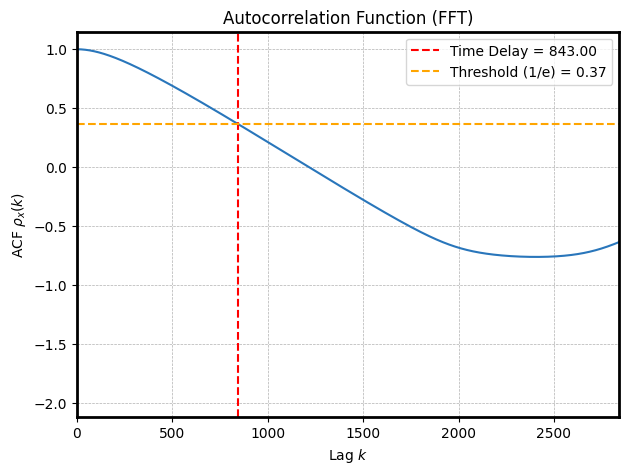

Selected  delay: 843.0


In [14]:
#  Plot the autocorrelation and mark the selected time delay
bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('Autocorrelation Function (FFT)')
ax.plot(time_delays, autocorrelation_values, color=bluish)
ax.set_xlabel(r'Lag $k$')
ax.set_ylabel(r'ACF $\rho_x(k)$')
plt.grid(True, which='both', ls='--', lw=0.5)

# Mark the time delay
ax.axvline(x=time_delay_value, color='r', linestyle='--', label=f'Time Delay = {time_delay_value:.2f}')
# Mark the threshold
ax.axhline(y=threshold, color='orange', linestyle='--', label=f'Threshold (1/e) = {threshold:.2f}')
set_spines_black(ax)
ax.legend()
ax.set_xlim(0, time_delay_idx + 2000) 
plt.savefig("Plots_3/TimeDelay_MassAction_model.pdf", bbox_inches="tight")
plt.show()
print(f"Selected  delay: {time_delay_value}")


## Embedding Dimesion

['false_nearest', '/tmp/pytisean_temp_2025-07-07-14-40-00_tcfi7a6l.dat', '-m', '1', '-M', '1,10', '-d', '843', '-f', '1.12', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-40-00_k042k6n8.dat']



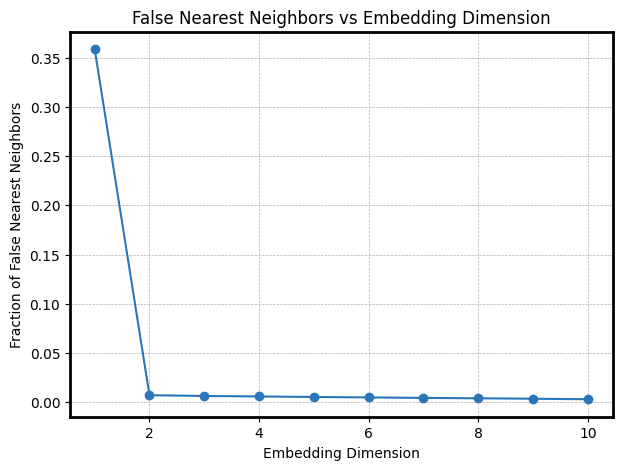

In [15]:
fnn_information, msg = tiseanio('false_nearest', '-m', 1, '-M', '1,10', '-d', 843, '-f',1.12, '-V',0, data=x_t)

# Plot the fraction of false nearest neighbors against embedding dimension

embedding_dimensions = fnn_information[:, 0]  # First column: embedding dimensions
fnn_values = fnn_information[:, 1]            # Second column: fraction of false nearest neighbors

bluish = '#2976bb'
fig, ax = plt.subplots(figsize=(7, 5), dpi=100)
ax.set_title('False Nearest Neighbors vs Embedding Dimension')
ax.plot(embedding_dimensions, fnn_values, color=bluish, marker='o')
ax.set_xlabel('Embedding Dimension')
ax.set_ylabel('Fraction of False Nearest Neighbors')
set_spines_black(ax)
plt.grid(True, which='both', ls='--', lw=0.5)
plt.savefig("Plots_3/Embedding_Dimension_MassAction_model.pdf", bbox_inches="tight")
plt.show()

In [16]:
fnn_values

array([0.3585454 , 0.00704379, 0.00630119, 0.00579884, 0.00526373,
       0.00481599, 0.00431364, 0.00393142, 0.00347275, 0.00298133])

In [17]:
## Time Delay = 843
## Embedding Dimension = consider 5

In [18]:
# To generate delay vectors
delay_information, msg = tiseanio('delay', '-m', 5, '-d', 843, '-V', 0, data=x_t)

['delay', '/tmp/pytisean_temp_2025-07-07-14-40-10_4o9plu10.dat', '-m', '5', '-d', '843', '-V', '0', '-o', '/tmp/pytisean_temp_2025-07-07-14-40-10_ikd006g2.dat']



In [19]:
delay_information

array([[2.625764e-01, 1.816394e-01, 1.145232e-01, 5.391427e-02,
        0.000000e+00],
       [2.626949e-01, 1.817239e-01, 1.145987e-01, 5.398241e-02,
        2.207672e-05],
       [2.628136e-01, 1.818084e-01, 1.146743e-01, 5.405056e-02,
        6.811668e-05],
       ...,
       [5.582479e-01, 6.366743e-01, 7.145370e-01, 2.923975e-01,
        2.006835e-01],
       [5.581396e-01, 6.365836e-01, 7.144693e-01, 2.925563e-01,
        2.007720e-01],
       [5.580313e-01, 6.364930e-01, 7.144012e-01, 2.927154e-01,
        2.008604e-01]])

In [20]:
# Extracting the Latent Features

In [21]:
# Perform SVD 
U, S, Vt = np.linalg.svd(delay_information,  full_matrices = False)

In [22]:
S

array([317.65671661,  95.90427335,  82.16967297,  27.79931065,
        26.76007947])

In [23]:
print(U)

[[-0.00086744  0.00196447 -0.00019674 -0.00045179  0.00292341]
 [-0.00086796  0.00196501 -0.00019669 -0.00045189  0.00292503]
 [-0.00086852  0.00196544 -0.00019679 -0.00045208  0.00292615]
 ...
 [-0.00340017  0.00350537  0.0028419  -0.00496622  0.00043512]
 [-0.00340013  0.00350304  0.00284166 -0.00496332  0.00043594]
 [-0.0034001   0.0035007   0.00284141 -0.00496041  0.00043677]]


In [24]:
print("Shape of embedded data:", delay_information.shape)
print("Shape of U:", U.shape)
print("Shape of S:", S.shape)
print("Shape of Vt:", Vt.shape)

Shape of embedded data: (96628, 5)
Shape of U: (96628, 5)
Shape of S: (5,)
Shape of Vt: (5, 5)


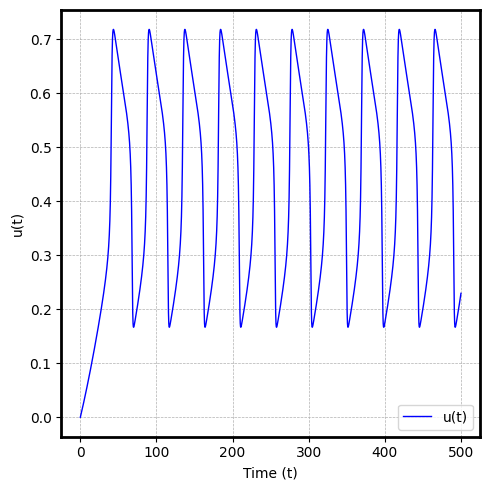

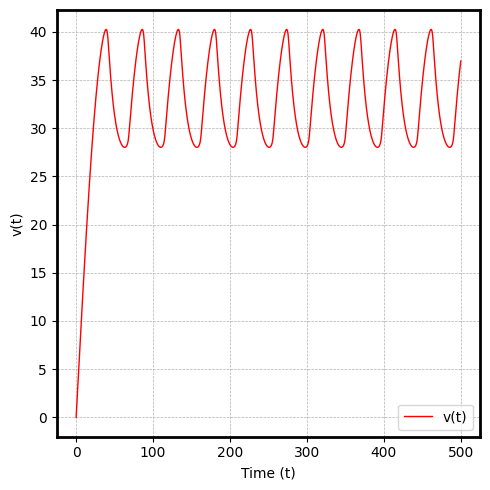

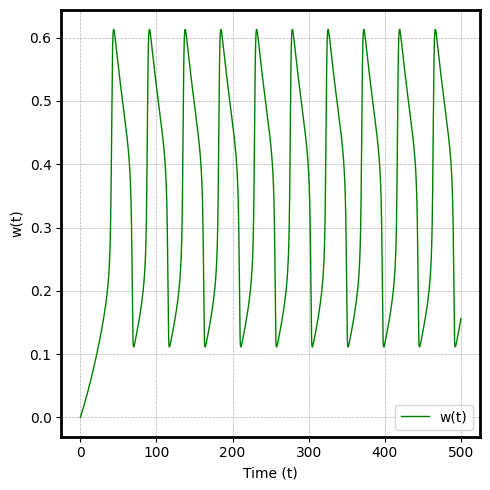

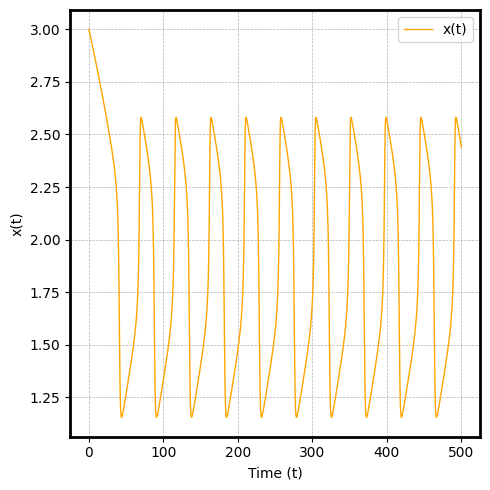

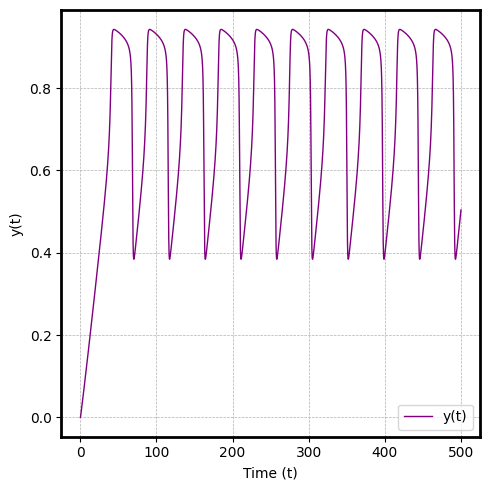

In [25]:
# Plot the time series obtained corresponding to each variable

# 1) u(t)
fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
ax1.plot(t_train[:50000], X[:, 0][:50000], color='b', lw=1.0, label='u(t)')
ax1.set(xlabel='Time (t)', ylabel='u(t)')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.show()



# 2) v(t)
fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=100)
ax2.plot(t_train[:50000], X[:, 1][:50000], color='r', lw=1.0, label='v(t)')
ax2.set(xlabel='Time (t)', ylabel='v(t)')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.show()


# 3) w(t)
fig3, ax3 = plt.subplots(figsize=(5, 5), dpi=100)
ax3.plot(t_train[:50000], X[:, 2][:50000], color='g', lw=1.0, label='w(t)')
ax3.set(xlabel='Time (t)', ylabel='w(t)')
ax3.legend(loc='best')
ax3.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax3)
fig3.tight_layout()
plt.show()


# 4) x(t)
fig4, ax4 = plt.subplots(figsize=(5, 5), dpi=100)
ax4.plot(t_train[:50000], X[:, 3][:50000], color='orange', lw=1.0, label='x(t)')
ax4.set(xlabel='Time (t)', ylabel='x(t)')
ax4.legend(loc='best')
ax4.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax4)
fig4.tight_layout()
plt.show()


# 5) y(t)
fig5, ax5 = plt.subplots(figsize=(5, 5), dpi=100)
ax5.plot(t_train[:50000], X[:, 4][:50000], color='purple', lw=1.0, label='y(t)')
ax5.set(xlabel='Time (t)', ylabel='y(t)')
ax5.legend(loc='best')
ax5.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax5)
fig5.tight_layout()
plt.show()


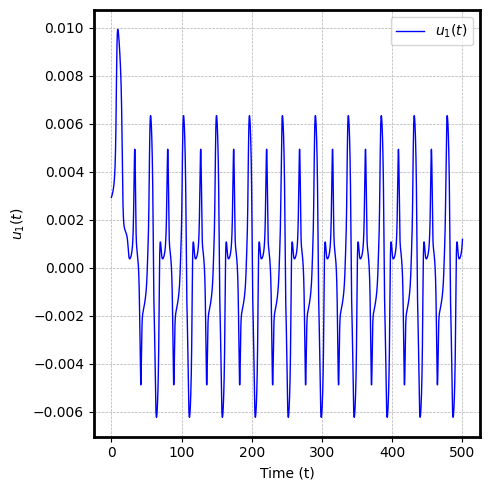

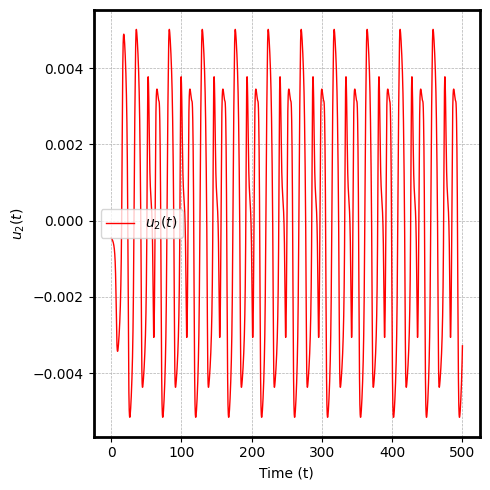

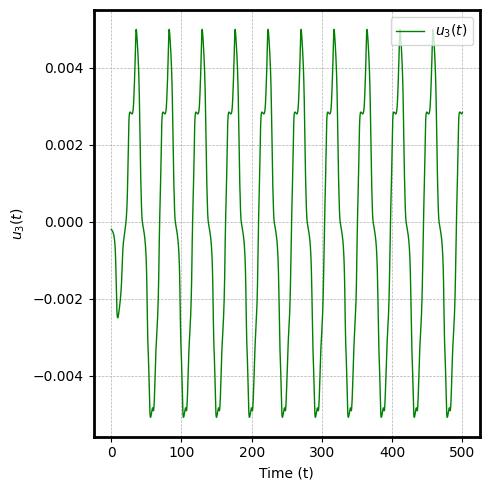

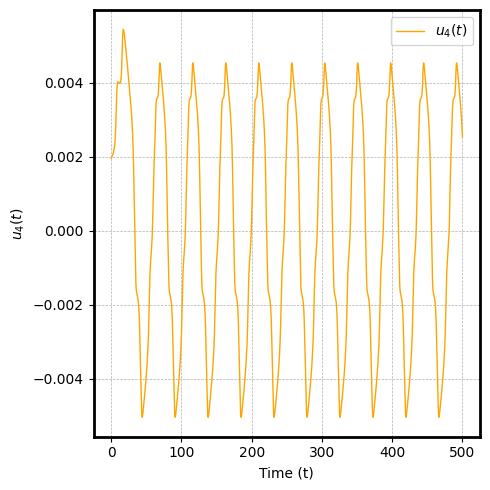

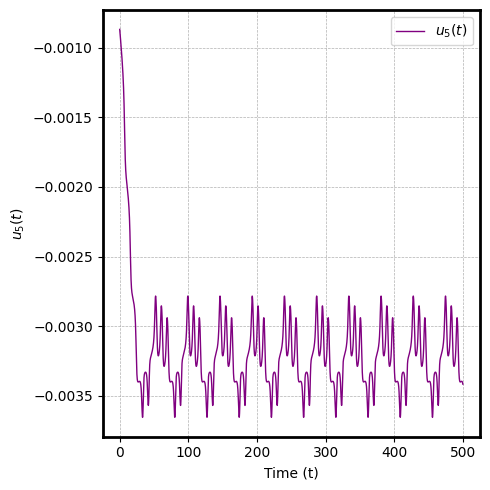

In [26]:
# Plot the time series obtained from the columns of U
min_len = min(len(t_train), len(U[:, 0]))
t_train = t_train[:min_len]
# Loop through each variable 
fig1, ax1 = plt.subplots(figsize=(5, 5), dpi=100)
ax1.plot(t_train[:50000], U[:, 4][:50000], color='b', lw=1.0, label='$u_1(t)$')
ax1.set(xlabel='Time (t)', ylabel='$u_1(t)$')
ax1.legend(loc='best')
ax1.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax1)
fig1.tight_layout()
plt.savefig("Plots_3/Latent_u1_MassAction_model.pdf", bbox_inches="tight")
plt.show()


# 2) v(t)
fig2, ax2 = plt.subplots(figsize=(5, 5), dpi=100)
ax2.plot(t_train[:50000], U[:, 3][:50000], color='r', lw=1.0, label=r'$u_2(t)$')
ax2.set(xlabel='Time (t)', ylabel=r'$u_2(t)$')
ax2.legend(loc='best')
ax2.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax2)
fig2.tight_layout()
plt.savefig("Plots_3/Latent_u2_MassAction_model.pdf", bbox_inches="tight")
plt.show()


# 3) w(t)
fig3, ax3 = plt.subplots(figsize=(5, 5), dpi=100)
ax3.plot(t_train[:50000], U[:, 2][:50000], color='g', lw=1.0, label=r'$u_3(t)$')
ax3.set(xlabel='Time (t)', ylabel=r'$u_3(t)$')
ax3.legend(loc='best')
ax3.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax3)
fig3.tight_layout()
plt.savefig("Plots_3/Latent_u3_MassAction_model.pdf", bbox_inches="tight")
plt.show()


# 4) x(t)
fig4, ax4 = plt.subplots(figsize=(5, 5), dpi=100)
ax4.plot(t_train[:50000], U[:, 1][:50000], color='orange', lw=1.0, label=r'$u_4(t)$')
ax4.set(xlabel='Time (t)', ylabel=r'$u_4(t)$')
ax4.legend(loc='best')
ax4.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax4)
fig4.tight_layout()
plt.savefig("Plots_3/Latent_u4_MassAction_model.pdf", bbox_inches="tight")
plt.show()


# 5) u(t)
fig5, ax5 = plt.subplots(figsize=(5, 5), dpi=100)
ax5.plot(t_train[:50000], U[:, 0][:50000], color='purple', lw=1.0, label=r'$u_5(t)$')
ax5.set(xlabel='Time (t)', ylabel=r'$u_5(t)$')
ax5.legend(loc='best')
ax5.grid(True, which='both', ls='--', lw=0.5)
set_spines_black(ax5)
fig5.tight_layout()
plt.savefig("Plots_3/Latent_u5_MassAction_model.pdf", bbox_inches="tight")
plt.show()



#####################################################################################################################################################